### 一、概述  
&emsp;&emsp;上一篇博客记录了MobileNet v1的学习过程，了解到该网络主要是由深度可分离卷积（depthwise + pointwise）“直筒状”拼接而成的简单神经网络。本博客为v2的学习笔记。为了切入重点，我们先来分析下MobileNet v1主要存在哪些缺点：
* 未使用Short cut
&emsp;&emsp;ResNet, DenseNet等结构早已证明，Short cut(或者skip connection)可以通过特征复用将多尺度的特征融合在一起，进而极大提升网络的性价比。而MobileNet v1由于年代较久远，还停留在“直筒状”结构。
* Depthwise与Non-linearity不搭
&emsp;&emsp;ShuffleNet和Xception中都建议depthwise conv后面不要使用non-linearity，在Xception中还有实验对比：

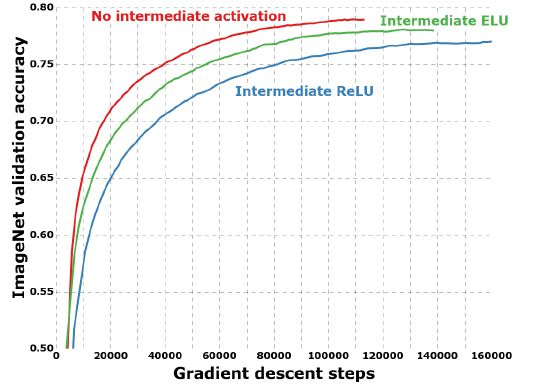

&emsp;&emsp;论文中提到的一个合理解释是：depth很关键，由于Inception中的中间层是全channel的，所以non-linearity是有利的，但是对于depthwise conv，其特征是单channle的，所以non-linearity有害，可能造成了信息丢失。

&emsp;&emsp;MobileNet v2就针对这两个问题作出了相应的改进。文章花了大量篇幅论述ReLU(也代表其他non-linearity)在对通道数较少（维度较低）的卷积层输出进行操作时，会造成信息的损失。因此如何避免ReLU的这一特性成为本文的核心改进方向。

&emsp;&emsp;MobileNet v1的主要问题在于相比MobileNet v1， v2主要引入了两个改进：**Linear Bottleneck和Inverted Residual Block**。  
v1和v2主要模块的对比：（图片出自：https://zhuanlan.zhihu.com/p/33075914）
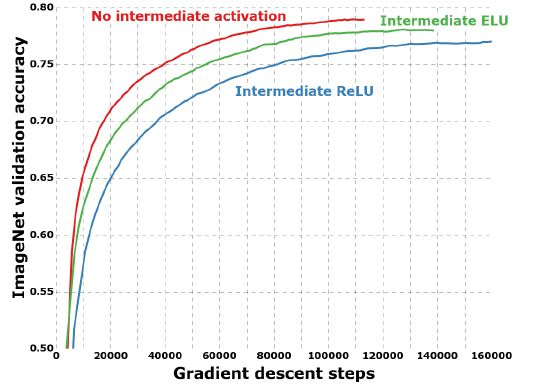

### 二、论文笔记    
#### 2.1 Manifold of interest    
   &emsp;&emsp;"Manifold of interest"，可以翻译成兴趣流形，是本文中最重要的概念之一。我的理解是，对于m个输入样本而言，网络每一层L_i的输出张量（注意是应用激活函数之前的张量）可以表述成 $h_i × w_i × d_i$的体素，其中d_i为该体素的深度，或者说**维度**（dimensionality）。**我们只拿其中一层L_i来说**，m个输入图像的信息在该层被映射为一个$h_i × w_i × d_i$的tensor。而该tensor中并不是每一个像素对于表征输入图像而言都是不可或缺的。可能只有一部分像素，就足够表征这些输入图像在该层的某种感兴趣信息（比如前几层可能是m个图像对应的轮廓，后几层是对应的眼睛鼻子等组件）。**这些真正“不可或缺”的像素，在$h_i × w_i × d_i$的特征空间中呈一个流形(manifold)分布。**，我们说这个兴趣流形是嵌入在特征空间的低维子空间(low-dimensional subspace)中的。  
     
   &emsp;&emsp;这个理论听起来似乎很有用，如果兴趣流形只存在于低维子空间中，那就可以对卷积层的输出特征进行降维，理想的情况是我们可以一直降维到该流形“张满”的那个特定维度对应的子空间。这样的显然可以节省大量的参数。该思想在MobileNet v1中得到了应用（weight multiplier）并取得了不错效果。  
     
   &emsp;&emsp;然而这个理论有一个严重的问题，就是以ReLU为代表的non-linearity会严重破坏输入空间的信息。举一个最简单的例子，1维空间中的直线经过ReLU会变成射线。而n维空间中的曲面经过ReLU可能只剩下具有n个节点的分段线性曲线。另一方面，从数值的角度说，ReLU会使激活feature map变稀疏。极端的情况，假如某一维（一个通道）的输出均为负数，那么通过ReLU之后，输出tensor相当于被降维了。 
     
   &emsp;&emsp;作者在Figure 1部分详细论述了这个问题：将一个二维的螺旋线（**代表2D空间中的1D流形**）通过随机矩阵T（后接RELU）转换至n-维tensor；再通过$T^{-1}$将其投影回2D空间。如果在转换过程中没有信息损失（比如去掉ReLU成为线性变换），则得到的2D矩阵应该和原来一样。然而由于ReLU的作用，当n较小时，恢复出来的图像出现了明显的“崩塌”，即流形中的很多点和其他点重叠到了一起。然而当n变大到15或30时，信息丢失会逐渐减少。这里的“崩塌(collapse)”可以理解成上一段中由于通道中所有数值为负而被ReLU降维这一现象。

&emsp;&emsp;根据上述分析以及实验，作者得到如下结论：如果每层卷积输出的tensor具有足够多的通道数，在经过ReLU之后，即便一些通道崩塌了，其他通道可能仍然保留了足够的信息。作者在论文后面给出了证明：**如果输入流形可以被嵌入到activation space的维度足够低的子空间中（换句话说就是特征空间维度足够高），那么ReLU就可以在保留信息的同时完成non-linearity的本职工作——提高模型的表达能力**。所以问题就变得清晰了——在必要的ReLU之前，提高卷积层输出tensor的维度。

#### 2.2 Linear Bottleneck  
&emsp;&emsp;经过上面的分析，现在可以很自然地引出改论文的第一个改进——Linear Bottleneck。Bottleneck这个词我也没找到严格的定义，感觉通常可以简单理解成维度较低的输出特征前面的层（比如这里depthwise之后的1x1卷积输出的特征即为bottleneck feature，所以每个block最后一个1x1卷积层即为Bottleneck）。所以Linear Bottleneck就是在1x1 conv之后去掉了non-linearity。之所以去掉这一层的ReLU也是因为Bottleneck比较薄，如果用ReLU的话就会出现上面的问题。

#### 2.3 Expansion Convolution Layer  
&emsp;&emsp;这一改进也是旨在解决同样的问题，即作者为了避免输入ReLU之前的特征太“薄”，特意先给输入特征升维。这里的升维也是通过1x1 Conv。这样一来，整个block从外观上看就是两头薄，中间厚，故该1x1 Conv被称为Expansion Conv。  
    &emsp;&emsp;此外，作者在该Block基础上又加上了short cut。其作用在于：①即便输入特征深度为0，也能利用short cut将卷积层转换为恒等映射。②利用short cut的通用功能，即特征融合。由于传统的残差块结构是中间薄，两头厚，所以作者将v2的这个`1x1 Expansion Conv - ReLU6 - Seperable Conv - ReLU6 - Linear Bottleneck`结构称为Inverted Residual Block.   
    &emsp;&emsp;一个小问题是，能不能不要ReLU，也不要Expansion Conv，都用Linear Conv？答案显然是不行的，作为提取特征的层必须有足够的表达能力，一个由纯linear layer组成的网络再深也只相当于一层。

In [1]:
import mxnet as mx
from mxnet.gluon import nn
from mxnet import nd, autograd
from mxnet.gluon import data as gdata
from mxnet.gluon.model_zoo import vision

### Step 1: 定义网络组件

* ReLU6  
ReLU6就是普通的ReLU但是限制最大输出值为6（对输出值做clip），这是为了在移动端设备float16的低精度的时候，也能有很好的数值分辨率，如果对ReLU的激活范围不加限制，输出范围为0到正无穷，如果激活值非常大，分布在一个很大的范围内，则低精度的float16无法很好地精确描述如此大范围的数值，带来精度损失。

In [4]:
class ReLU6(nn.HybridBlock):
    def __init__(self, **kwags):
        super(ReLU6, self).__init__(**kwags)
    
    def hybrid_forward(self, F, x):
        return F.clip(x, 0, 6)

def ConvBlock(channels, kernel_size, strides, padding=1, groups=1, activation='relu6'):
    block = nn.HybridSequential()
    block.add(nn.Conv2D(channels, kernel_size, strides, padding=padding, groups=groups, use_bias=False))
    block.add(nn.BatchNorm())
    if activation is not None:
        block.add(ReLU6(prefix='relu6_'))
    return block

def DepthWiseConv(channels, strides):
    return ConvBlock(channels, 3, strides, groups=channels)
    
def LinearBottleneck(channels):
    return ConvBlock(channels, 1, 1, 0, activation=None)

def ExpansionConv(channels):
    return ConvBlock(channels, 1, 1, 0)

class InvertedResidual(nn.HybridBlock):
    def __init__(self, in_channels, out_channels, strides, t=6, **kwags):
        super(InvertedResidual,self).__init__(**kwags)
        self.strides = strides
        self.keep_channels = in_channels == out_channels
        expanded_channels = t * in_channels
        self.inver_residual = nn.HybridSequential()
        with self.inver_residual.name_scope():
            self.inver_residual.add(ExpansionConv(expanded_channels),
                                DepthWiseConv(expanded_channels, strides),
                                LinearBottleneck(out_channels))
    
    def hybrid_forward(self, F, x):
        out = self.inver_residual(x)
        if self.strides == 1 and self.keep_channels:
            out = out + x
            #out = F.elemwise_add(out, x)
        return out
    
def RepeatedInvertedResiduals(in_channels, out_channels, repeats, strides, t, **kwags):
    sequence = nn.HybridSequential(**kwags)
    # The first layer of each sequence has a stride s and all others use stride 1.
    sequence.add(InvertedResidual(in_channels, out_channels, strides, t))
    for _ in range(1, repeats):
        sequence.add(InvertedResidual(out_channels, out_channels, 1, t))
    return sequence

class MobileNetV2(nn.HybridBlock):
    def __init__(self, num_classes, width_multiplier=1.0, **kwags):
        super(MobileNetV2, self).__init__(**kwags)
        input_feature_channels = int(32 * width_multiplier)
        
        self.bottleneck_settings = [
            # t, c, n, s
            [1, 16, 1, 1, "stage0_"],      # -> 112x112
            [6, 24, 2, 2, "stage1_"],      # -> 56x56
            [6, 32, 3, 2, "stage2_"],      # -> 28x28
            [6, 64, 4, 2, "stage3_0_"],    # -> 14x14
            [6, 96, 3, 1, "stage3_1_"],    # -> 14x14
            [6, 160, 3, 2, "stage4_0_"],   # -> 7x7
            [6, 320, 1, 1, "stage4_1_"],   # -> 7x7
        ]
        self.net = nn.HybridSequential()
        self.net.add(ConvBlock(input_feature_channels, 3, 2))
        
        in_channels = input_feature_channels
        for t, c, n, s, prefix in self.bottleneck_settings:
            out_channels = int(width_multiplier * c)
            self.net.add(RepeatedInvertedResiduals(in_channels, out_channels, n, s, t, prefix=prefix))
            in_channels = out_channels  # 下一层的输入通道数为当前层的输出通道数
        
        # 注意：MobileNetV2使用的分类头不是GAP + Dense，而是GAP + 1x1 Linear Conv + Flatten
        self.net.add(ConvBlock(int(1280*width_multiplier), 1, 1, 0),
                          nn.GlobalAvgPool2D(),
                          nn.Conv2D(num_classes, 1, 1, 0, activation=None, use_bias=False),
                          nn.Flatten())
    
    def hybrid_forward(self, F, x):
        return self.net(x)

* 网络维度检查：比较上面定义的网络和官方的网络维度和参数是否一致。  
（结果：一致。由于输出列表太长，故省略）

In [ ]:
net = MobileNetV2(1000)
net.initialize(init=mx.init.Xavier())
test_input = nd.random_normal(shape=(1,3,224,224))
net.summary(test_input)

In [ ]:
net_official = vision.mobilenet_v2_1_0()
net_official.initialize(mx.init.Xavier())
net_official.summary(test_input)

In [5]:
from gluoncv.data import transforms as gcv_transforms
from mxnet.gluon.data.vision import transforms
from gluoncv.model_zoo import get_model
from mxnet import gluon
from mxnet.gluon.utils import split_and_load
from utils.utils import plot_train_log
import mxnet as mx
import pdb
import time

In [6]:
def get_dataloader():
    transform_train = transforms.Compose([
        # pad 4 之后在40x40区域中随机crop出32x32，提高网络translation invariance
        # 这里代替了gdata.transforms.RandomCropResize
        gcv_transforms.RandomCrop(32, pad=4),  
        transforms.RandomFlipLeftRight(),
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
    ])
    train_iter = gdata.DataLoader(gdata.vision.CIFAR10().transform_first(transform_train), batch_size=BATCH_SIZE, 
                                  shuffle=True, last_batch='discard', num_workers=-1)
    test_iter = gdata.DataLoader(gdata.vision.CIFAR10(train=False).transform_first(transform_test), batch_size=BATCH_SIZE, 
                                  shuffle=False, num_workers=-1)
    return train_iter, test_iter

In [58]:
# # 测试num_workers：取-1时速度最快
# #### Configs:
# BATCH_SIZE = 64  # per gpu  
# EPOCHS = 200
# train_iter, test_iter = get_dataloader()
# tic = time.time()
# for X, y in train_iter:
#     print(X.shape, y.shape)
#     print("time: {}".format(time.time()-tic))
#     break

(64, 3, 32, 32) (64,)
time: 0.025723934173583984


In [7]:
def evaluate(model, test_iter, ctx):
    metric_val = mx.metric.Accuracy()
    val_loss = 0
    for X, y in test_iter:
        X = split_and_load(X, ctx)
        y = split_and_load(y, ctx)
        outputs = [model(x) for x in X]
        loss = [criterion(output, target) for output, target in zip(outputs, y)]
        val_loss += sum([l.mean().asscalar() for l in loss])/len(ctx)
        metric_val.update(y, outputs)
    return metric_val.get()[1], val_loss/len(test_iter)

def train(model, trainer, train_iter, test_iter, criterion, ctx, batchSize, epochs, lr_decay_dict=None):
    metric = mx.metric.Accuracy()
    for epoch in range(epochs):
        tic = time.time()
        metric.reset()
        train_loss_avg = 0
        for it, (X, y) in enumerate(train_iter):
            X = split_and_load(X, ctx)
            y = split_and_load(y, ctx)
            with autograd.record():
                logits = [model(x) for x in X]
                loss = [criterion(logit, label) for logit,label in zip(logits, y)]
            for l in loss:
                l.backward() 
            # 每个iteration将当期batch的平均loss加入loss_history
            train_loss_avg += sum([l.mean().asscalar() for l in loss])/2
            trainer.step(BATCH_SIZE)
            metric.update(y, logits)
        if lr_decay_dict is not None:
            if epoch in lr_decay_dict.keys():
                trainer.set_learning_rate(trainer.learning_rate * lr_decay_dict[epoch])
        name, accuracy = metric.get()
        val_acc, val_loss = evaluate(model, test_iter, ctx)
        print("Epoch {}, train_acc: {:.4f}, train_loss: {:.4f}, val_acc: {:.4f}, val_loss: {:.4f} epoch time: {:.4f}  lr: {:.6f}".format(
               epoch, accuracy, train_loss_avg/len(train_iter), val_acc, val_loss, time.time()-tic, trainer.learning_rate))
        if val_loss<0.7:
            model.save_parameters('best_params_acc_{:.4f}_loss_{:.4f}.params'.format(val_acc, val_loss))

### Step 2: Training  
训练参数参考： https://gluon-cv.mxnet.io/model_zoo/classification.html#cifar10  
使用nag optimizer，WD，Momentum以及steps decay。  
* 问题：模型只有8M多，但是训练一个epoch要八十多秒，理想时间应该是十一二秒。是gcv_transforms还是depthwise conv，还是没使用synchronize batchnorm导致训练这么慢？

In [6]:
if __name__ == "__main__":
    CTX=[mx.gpu(0), mx.gpu(1)]
    BATCH_SIZE = 64  # per gpu
    EPOCHS = 200
    LR = 1e-1
    WD = 5e-4
    MOMENTUM = 0.9
    
    train_iter, test_iter = get_dataloader()
    net = MobileNetV2(10)
    net.initialize(init=mx.init.Xavier(), ctx=CTX)
    net.hybridize()
    
    trainer = gluon.Trainer(net.collect_params(), 'nag', 
                           {'learning_rate':LR,'wd':WD, 'momentum':MOMENTUM})
    criterion = gluon.loss.SoftmaxCrossEntropyLoss(sparse_label=True)
    lr_decay_dict = {40:0.1, 80:0.1, 120:0.1}
    train(net, trainer, train_iter, test_iter, criterion, CTX, BATCH_SIZE, EPOCHS, lr_decay_dict)

Epoch 0, train_acc: 0.2039, train_loss: 2.3300, val_acc: 0.2595, val_loss: 1.9208 epoch time: 93.3272  lr: 0.100000
Epoch 1, train_acc: 0.2909, train_loss: 1.8855, val_acc: 0.3473, val_loss: 1.8096 epoch time: 84.2588  lr: 0.100000
Epoch 2, train_acc: 0.3380, train_loss: 1.7828, val_acc: 0.3835, val_loss: 1.7298 epoch time: 85.3270  lr: 0.100000
Epoch 3, train_acc: 0.3782, train_loss: 1.6849, val_acc: 0.4236, val_loss: 1.5758 epoch time: 84.5955  lr: 0.100000
Epoch 4, train_acc: 0.4158, train_loss: 1.5887, val_acc: 0.4347, val_loss: 1.5496 epoch time: 82.9706  lr: 0.100000
Epoch 5, train_acc: 0.4557, train_loss: 1.5108, val_acc: 0.4428, val_loss: 1.5503 epoch time: 85.3645  lr: 0.100000
Epoch 6, train_acc: 0.4806, train_loss: 1.4361, val_acc: 0.4966, val_loss: 1.4958 epoch time: 84.1498  lr: 0.100000
Epoch 7, train_acc: 0.4990, train_loss: 1.3980, val_acc: 0.4992, val_loss: 1.4311 epoch time: 84.5777  lr: 0.100000
Epoch 8, train_acc: 0.5143, train_loss: 1.3586, val_acc: 0.5002, val_los

Epoch 71, train_acc: 0.7195, train_loss: 0.8109, val_acc: 0.7287, val_loss: 0.7864 epoch time: 83.8081  lr: 0.010000
Epoch 72, train_acc: 0.7193, train_loss: 0.8133, val_acc: 0.7240, val_loss: 0.8109 epoch time: 82.9100  lr: 0.010000
Epoch 73, train_acc: 0.7224, train_loss: 0.8114, val_acc: 0.7335, val_loss: 0.7728 epoch time: 84.8542  lr: 0.010000
Epoch 74, train_acc: 0.7206, train_loss: 0.8105, val_acc: 0.7348, val_loss: 0.7788 epoch time: 83.2092  lr: 0.010000
Epoch 75, train_acc: 0.7225, train_loss: 0.8135, val_acc: 0.7372, val_loss: 0.7726 epoch time: 83.4324  lr: 0.010000
Epoch 76, train_acc: 0.7220, train_loss: 0.8054, val_acc: 0.7221, val_loss: 0.8065 epoch time: 83.8976  lr: 0.010000
Epoch 77, train_acc: 0.7250, train_loss: 0.8060, val_acc: 0.7474, val_loss: 0.7428 epoch time: 85.0606  lr: 0.010000
Epoch 78, train_acc: 0.7253, train_loss: 0.8065, val_acc: 0.7357, val_loss: 0.7910 epoch time: 84.9687  lr: 0.010000
Epoch 79, train_acc: 0.7206, train_loss: 0.8099, val_acc: 0.7463

Epoch 141, train_acc: 0.7967, train_loss: 0.5957, val_acc: 0.8026, val_loss: 0.5742 epoch time: 83.1249  lr: 0.000100
Epoch 142, train_acc: 0.7982, train_loss: 0.5919, val_acc: 0.8003, val_loss: 0.5794 epoch time: 83.7489  lr: 0.000100
Epoch 143, train_acc: 0.7977, train_loss: 0.5913, val_acc: 0.8041, val_loss: 0.5759 epoch time: 83.5252  lr: 0.000100
Epoch 144, train_acc: 0.7978, train_loss: 0.5926, val_acc: 0.8014, val_loss: 0.5734 epoch time: 84.1328  lr: 0.000100
Epoch 145, train_acc: 0.7985, train_loss: 0.5920, val_acc: 0.8013, val_loss: 0.5752 epoch time: 83.3623  lr: 0.000100
Epoch 146, train_acc: 0.7973, train_loss: 0.5927, val_acc: 0.8029, val_loss: 0.5726 epoch time: 84.4763  lr: 0.000100
Epoch 147, train_acc: 0.7988, train_loss: 0.5916, val_acc: 0.8028, val_loss: 0.5732 epoch time: 83.3006  lr: 0.000100
Epoch 148, train_acc: 0.7965, train_loss: 0.5932, val_acc: 0.7993, val_loss: 0.5734 epoch time: 84.2138  lr: 0.000100
Epoch 149, train_acc: 0.7977, train_loss: 0.5875, val_ac

### Step 3: Evaluating

In [39]:
from sklearn.metrics import classification_report

In [51]:
CTX = mx.gpu(0)
CATEGORIES = ['airplane', 'automobile', 'bird','cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
net = MobileNetV2(10)
net.load_parameters('best_params_acc_0.8026_loss_0.5658.params',ctx=CTX)
transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
    ])
test_iter = gdata.DataLoader(gdata.vision.CIFAR10(train=False).transform_first(transform_test), batch_size=10000, 
                                  shuffle=False, num_workers=-1)
print('[INFO] Start evaluating...')
for X, y in test_iter:
    X = X.as_in_context(CTX)
    y = y.as_in_context(CTX)
    preds  = net(X).argmax(axis=1)
    print(classification_report(y.asnumpy(), preds.asnumpy(), target_names=CATEGORIES))

[INFO] Start evaluating...
              precision    recall  f1-score   support

    airplane       0.79      0.83      0.81      1000
  automobile       0.90      0.90      0.90      1000
        bird       0.73      0.74      0.73      1000
         cat       0.63      0.66      0.65      1000
        deer       0.80      0.79      0.79      1000
         dog       0.74      0.66      0.69      1000
        frog       0.83      0.88      0.85      1000
       horse       0.86      0.82      0.84      1000
        ship       0.89      0.89      0.89      1000
       truck       0.87      0.88      0.87      1000

   micro avg       0.80      0.80      0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



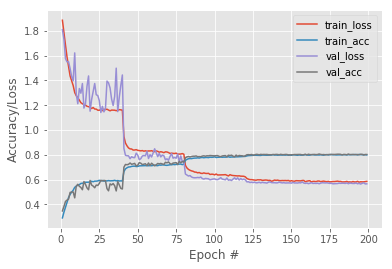

In [3]:
!cat train_mobile2.log | awk -F ", |: | +" '{print $2"\t"$4"\t"$6"\t"$8"\t"$10}' > train_mobile2.csv
plot_train_log('train_mobile2.csv')

### 代码实验区

* 实验：检查train函数是否有bug

In [18]:
if __name__ == "__main__":
    CTX=[mx.gpu(0), mx.gpu(1)]
    BATCH_SIZE = 64  # per gpu
    EPOCHS = 200
    LR = 1e-1
    WD = 5e-4
    MOMENTUM = 0.9
    
    train_iter, test_iter = get_dataloader()
    net = get_model('cifar_wideresnet16_10')
    net.initialize(init=mx.init.Xavier(), ctx=CTX)
    net.hybridize()
    
    trainer = gluon.Trainer(net.collect_params(), 'nag', 
                           {'learning_rate':LR,'wd':WD, 'momentum':MOMENTUM})
    criterion = gluon.loss.SoftmaxCrossEntropyLoss(sparse_label=True)
    lr_decay_dict = {60:0.1, 120:0.1, 160:0.1}
    train(net, trainer, train_iter, test_iter, criterion, CTX, BATCH_SIZE, EPOCHS, lr_decay_dict)

Epoch 0, train_acc: 0.4256, train_loss: 1.5638, val_acc: 0.5833, val_loss: 1.1721 epoch time: 76.7416  lr: 0.100000
Epoch 1, train_acc: 0.6390, train_loss: 1.0242, val_acc: 0.6686, val_loss: 1.0157 epoch time: 75.9518  lr: 0.100000
Epoch 2, train_acc: 0.7223, train_loss: 0.7984, val_acc: 0.7015, val_loss: 0.9132 epoch time: 75.8572  lr: 0.100000
Epoch 3, train_acc: 0.7638, train_loss: 0.6871, val_acc: 0.7664, val_loss: 0.6948 epoch time: 75.5993  lr: 0.100000
Epoch 4, train_acc: 0.7863, train_loss: 0.6224, val_acc: 0.6340, val_loss: 1.1259 epoch time: 75.8627  lr: 0.100000
Epoch 5, train_acc: 0.7986, train_loss: 0.5895, val_acc: 0.7281, val_loss: 0.8899 epoch time: 76.2686  lr: 0.100000
Epoch 6, train_acc: 0.8071, train_loss: 0.5631, val_acc: 0.7301, val_loss: 0.8236 epoch time: 76.4512  lr: 0.100000
Epoch 7, train_acc: 0.8175, train_loss: 0.5354, val_acc: 0.7645, val_loss: 0.6954 epoch time: 76.4710  lr: 0.100000
Epoch 8, train_acc: 0.8203, train_loss: 0.5253, val_acc: 0.7734, val_los

KeyboardInterrupt: 

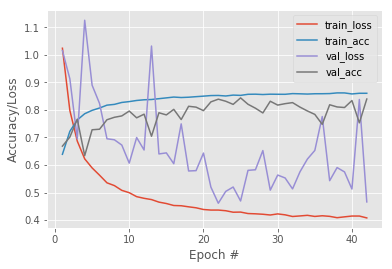

In [20]:
!cat train_wideresnet.log | awk -F ", |: | +" '{print $2"\t"$4"\t"$6"\t"$8"\t"$10}' > train_wideresnet.csv
plot_train_log('train_wideresnet.csv')

In [55]:
from mxnet import gluon
gluon.loss.SoftmaxCrossEntropyLoss()

In [5]:
import numpy as np
np.clip([-1,2,3,5,6,7,8], 0, 6)

array([0, 2, 3, 5, 6, 6, 6])